In [202]:
import matplotlib.pyplot as plt
%matplotlib inline

import os
import os.path as op
import numpy as np
import nibabel as nb

from pyhrf.ndarray import xndarray
from pyhrf.plot import autocrop

archives = op.join('/media', 'aina', 'MISTIS', 'Data')
folder = op.join(archives, 'tests_HEROES')
if not op.exists(folder): os.mkdir(folder)
#data_fn = op.join(archives, 'HEROES_preprocessed', 'AC150013', 'Preprocessed',
#                  'wravismot1_BOLDepi2_ac150013_20150121_acq1_11.nii')
data_fn = op.join(archives, 'HEROES_preprocessed', 'AC150013', 'Preprocessed',
                  'wravismot2_BOLDepi1_ac150013_20150121_acq1_06.nii')
paradigm_fn = op.join(archives, 'HEROES_DB', 'paradigm_data', 'paradigm_bilateral_v2_no_final_rest.csv')

### The experimental paradigm

In [203]:
from pyhrf.paradigm import Paradigm

paradigm = Paradigm.from_csv(paradigm_fn)
conditions = paradigm.get_stimulus_names()
onsets = paradigm.get_joined_onsets()
durations = paradigm.get_joined_durations()
print 'conditions: ', conditions
print 'onsets: ', onsets
print 'durations: ', durations

conditions:  ['checkerboard_motor_d5000_left', 'checkerboard_motor_d2500_right', 'checkerboard_motor_d2500_left', 'checkerboard_motor_d5000_right']
onsets:  OrderedDict([('checkerboard_motor_d5000_left', array([ 105.,  180.,  280.,  380.])), ('checkerboard_motor_d2500_right', array([  80.,  155.,  205.,  330.])), ('checkerboard_motor_d2500_left', array([  30.,   55.,  230.,  305.])), ('checkerboard_motor_d5000_right', array([   5.,  130.,  255.,  355.]))])
durations:  OrderedDict([('checkerboard_motor_d5000_left', array([ 15.,  15.,  15.,  15.])), ('checkerboard_motor_d2500_right', array([ 15.,  15.,  15.,  15.])), ('checkerboard_motor_d2500_left', array([ 15.,  15.,  15.,  15.])), ('checkerboard_motor_d5000_right', array([ 15.,  15.,  15.,  15.]))])


In [204]:
from nistats import hemodynamic_models
from scipy.signal import convolve

max_time = 410
TR, oversampling, time_length = 2.5, 1., 25.
time_grid = np.mgrid[0:max_time:1.]
time_line = np.zeros((len(time_grid)))

for cond in onsets:
    for ions, ons in enumerate(onsets[cond]):
        time_line[ons: (ons+durations[cond][ions] + 1)] = 1.
#print time_line

hrf = hemodynamic_models.glover_hrf(tr=TR, oversampling=oversampling, time_length=time_length)
hrf /= np.linalg.norm(hrf)
continuous_regressors = convolve(time_line, hrf, mode='full')

[0, 100, -1, 2]

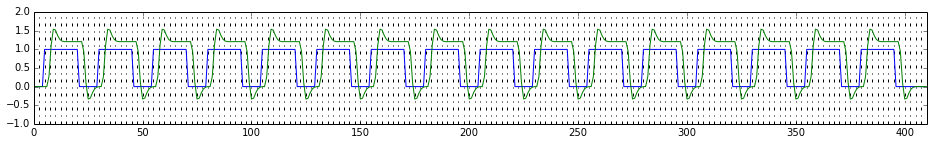

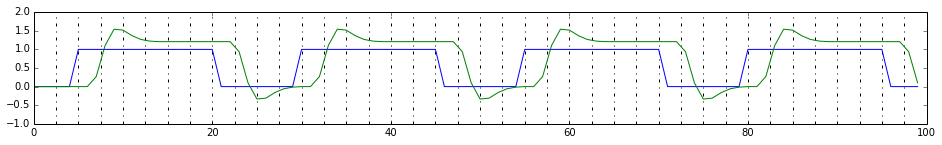

In [205]:
plt.figure(figsize=(16, 2))
plt.plot(time_grid, time_line)
plt.plot(continuous_regressors)
plt.vlines(np.arange(0, time_grid.max(), TR), -1, 12, linestyle='-.')
plt.axis([0, max_time, -1, 2])

plt.figure(figsize=(16, 2))
plt.plot(time_grid[:100], time_line[:100])
plt.plot(continuous_regressors[:100])
plt.vlines(np.arange(0, 100, TR), -1, 12, linestyle='-.')
plt.axis([0, 100, -1, 2])

### The signal

[0, 100, -1, 2]

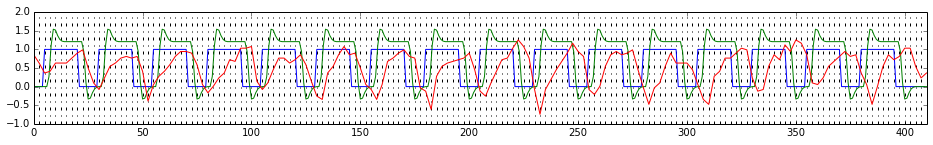

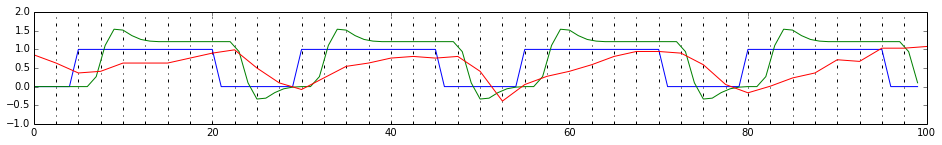

In [206]:
# Load data and parameters
t_r = 2.5
niimg = nb.load(data_fn)
bold_data = niimg.get_data()
n_scans = bold_data.shape[3]
frametimes = np.arange(0, n_scans * t_r, t_r)

vox = [26, 9, 25]
vox = [29, 8, 22]
#vox = [28, 10, 22]

timeseries = bold_data[vox[0], vox[1], vox[2], :]
timeseries_0 = timeseries - timeseries.mean()
timeseries_scaled = timeseries_0 / (timeseries_0.max() - timeseries_0.min()) * 2 + 0.5 

plt.figure(figsize=(16, 2))
plt.plot(time_grid, time_line)
plt.plot(continuous_regressors)
plt.plot(frametimes, timeseries_scaled)
plt.vlines(np.arange(0, time_grid.max(), TR), -1, 12, linestyle='-.')
plt.axis([0, max_time, -1, 2])

plt.figure(figsize=(16, 2))
plt.plot(time_grid[:100], time_line[:100])
plt.plot(continuous_regressors[:100])
plt.plot(frametimes[:41], timeseries_scaled[:41])
plt.vlines(np.arange(0, 100, TR), -1, 12, linestyle='-.')
plt.axis([0, 100, -1, 2])

There is a delay between signal and paradigm!!! where does it come from?? Check events files from paradigm!!
By checking the events file, we see that from start to start of stimulus there are 5 secs, as we saw in the paradigm.
This acquisition started at 10:54:14, and stimulus 0 is at +1789.096secs. So the acquistion of BOLD with paradigm v2 started at 11:24:03. In the acquisition data it said 11:21, but that was checked manually.

There seems to be a delay sometimes, but more importantly ther seem to be a jitter in the blocks. Is that happening? Let's check...

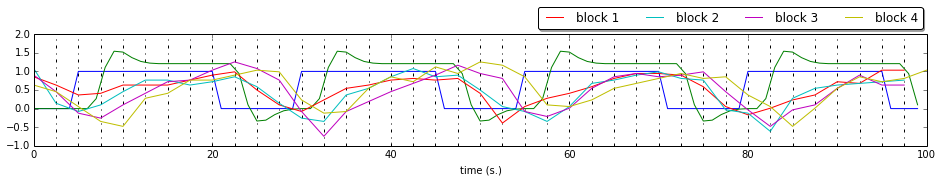

In [209]:
plt.figure(figsize=(16, 2))
plt.plot(time_grid[:100], time_line[:100])
plt.plot(continuous_regressors[:100])
plt.plot(frametimes[:40], timeseries_scaled[:40], label='block 1')
plt.plot(frametimes[:40], timeseries_scaled[40:80], label='block 2')
plt.plot(frametimes[:40], timeseries_scaled[80:120], label='block 3')
plt.plot(frametimes[:45], timeseries_scaled[120:], label='block 4')
plt.vlines(np.arange(0, 100, TR), -1, 12, linestyle='-.')
plt.axis([0, 100, -1, 2])
plt.xlabel('time (s.)')
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1.30), ncol=4, fancybox=True, shadow=True)

There is clearly a delay between the blocks!!! Every 100 secs we have 4 blocks.
If we check the events file, the task+rest cycles ar not 25 secs but 25.3 secs or 25.4 secs. Therefore, every 3 cycles we have a delay of 1 sec with respect to the data!!!! This is the problem...

What if we now use a paradigm considering this??

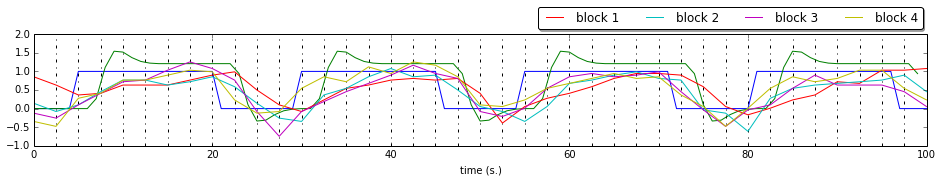

In [211]:
paradigm_fn2 = op.join(archives, 'HEROES_DB', 'paradigm_data', 'paradigm_bilateral_v2_no_final_rest_delay.csv')
paradigm2 = Paradigm.from_csv(paradigm_fn2)
conditions = paradigm2.get_stimulus_names()
onsets = paradigm2.get_joined_onsets()
durations = paradigm2.get_joined_durations()

time_line = np.zeros((len(time_grid)))
for cond in onsets:
    for ions, ons in enumerate(onsets[cond]):
        time_line[ons: (ons+durations[cond][ions] + 1)] = 1.
continuous_regressors = convolve(time_line, hrf, mode='full')

plt.figure(figsize=(16, 2))
plt.plot(time_grid[:102], time_line[:102])
plt.plot(continuous_regressors[:100])
plt.plot(frametimes[:41], timeseries_scaled[:41], label='block 1')
plt.plot(frametimes[:41], timeseries_scaled[41:82], label='block 2')
plt.plot(frametimes[:41], timeseries_scaled[82:123], label='block 3')
plt.plot(frametimes[:42], timeseries_scaled[123:], label='block 4')
plt.vlines(np.arange(0, 100, TR), -1, 12, linestyle='-.')
plt.axis([0, 100, -1, 2])
plt.xlabel('time (s.)')
plt.legend(loc='upper center', bbox_to_anchor=(0.78, 1.30), ncol=4, fancybox=True, shadow=True)

Now 4 blocks take 101.5 seconds because the blocks are longer. If we plot the blocks together we have a better correspondence.

### The design matrix

    run                            name   onset  duration  modulation
0     0   checkerboard_motor_d5000_left  106.40     15.35           1
1     0   checkerboard_motor_d5000_left  182.45     15.35           1
2     0   checkerboard_motor_d5000_left  283.75     15.35           1
3     0   checkerboard_motor_d5000_left  385.15     15.35           1
4     0  checkerboard_motor_d2500_right   81.05     15.35           1
5     0  checkerboard_motor_d2500_right  157.10     15.35           1
6     0  checkerboard_motor_d2500_right  207.80     15.35           1
7     0  checkerboard_motor_d2500_right  334.45     15.35           1
8     0   checkerboard_motor_d2500_left   30.35     15.35           1
9     0   checkerboard_motor_d2500_left   55.70     15.35           1
10    0   checkerboard_motor_d2500_left  233.15     15.35           1
11    0   checkerboard_motor_d2500_left  309.10     15.35           1
12    0  checkerboard_motor_d5000_right    5.00     15.35           1
13    0  checkerboar

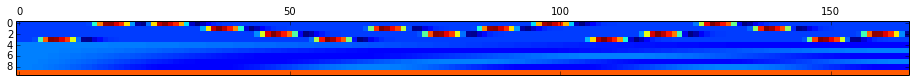

In [214]:
from nistats.glm import FirstLevelGLM
from nistats import experimental_paradigm, design_matrix

# Build design matrix
paradigm_fn = op.join(archives, 'HEROES_DB', 'paradigm_data', 'paradigm_bilateral_v2_no_final_rest_delay_notebook.csv')
paradigm = experimental_paradigm.paradigm_from_csv(paradigm_fn)
print paradigm
dm = design_matrix.make_design_matrix(frametimes, paradigm=paradigm)
plt.matshow(dm.T)

### GLM analysis

In [215]:
from nilearn.input_data import NiftiMasker
from nistats import glm

# Construct masker and run GLM
affine = niimg.get_affine()
masker = NiftiMasker(mask_strategy='epi')
niimgs_masked = masker.fit_transform(niimg)
glm_results = glm.session_glm(niimgs_masked, dm, noise_model='ols')
labels = glm_results[0]
reg_results = glm_results[1]

In [216]:
norm_resid = (np.linalg.norm(reg_results[0].resid, axis=0)).mean()
sqnorm_resid = (np.linalg.norm(reg_results[0].resid, axis=0)**2).mean()
print 'Residual norm = ', norm_resid
print 'Squared residual norm = ', sqnorm_resid
print
print 'conditions:'
print dm.keys()[0]
print dm.keys()[1]
print dm.keys()[2]
print dm.keys()[3]

Residual norm =  54.010418352
Squared residual norm =  3968.90858587

conditions:
checkerboard_motor_d2500_left
checkerboard_motor_d2500_right
checkerboard_motor_d5000_left
checkerboard_motor_d5000_right


d2500
d5000
d2500_left
d2500_right
d5000_left
d5000_right


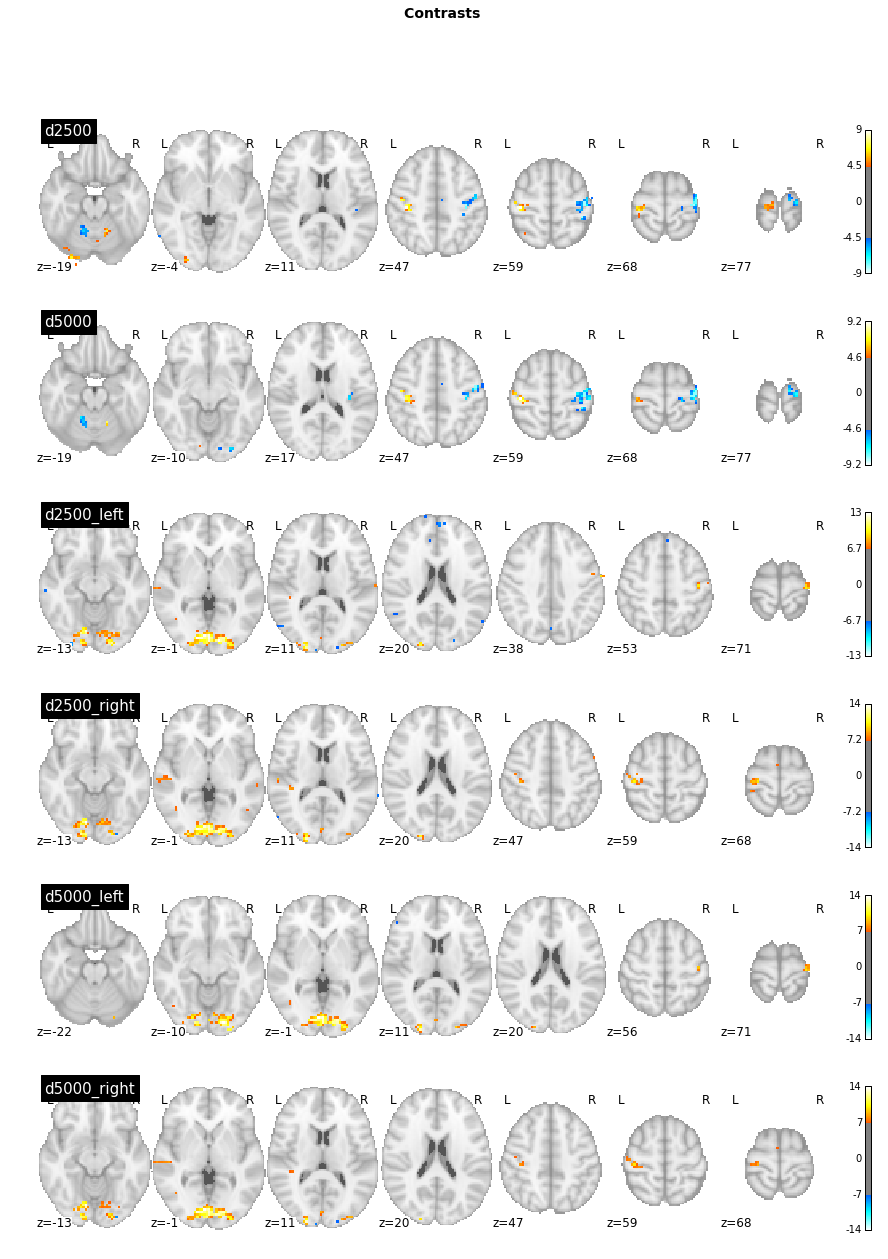

In [217]:
from nilearn.plotting import plot_stat_map, plot_glass_brain
from nipy.labs.viz import plot_map, cm

# Compute contrasts
contrasts = [np.array([-1, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 0,-1, 1, 0, 0, 0, 0, 0, 0]),
             np.array([ 1, 0, 0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 1, 0, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 0, 1, 0, 0, 0, 0, 0, 0, 0]),
             np.array([ 0, 0, 0, 1, 0, 0, 0, 0, 0, 0])]
names = ['d2500', 'd5000', 'd2500_left', 'd2500_right', 'd5000_left', 'd5000_right']

f, ax = plt.subplots(len(contrasts), 1, figsize=(15, 20))
f.suptitle('Contrasts ', fontsize=14, fontweight='bold')
for i in xrange(len(contrasts)):
    print names[i]
    contrast_map = glm.compute_contrast(labels, reg_results, contrasts[i])
    pvalues = contrast_map.p_value()
    pvalues_img = masker.inverse_transform(pvalues)
    zscore = contrast_map.z_score()
    zscore_img = masker.inverse_transform(zscore)
    
    ind_min_unravel = np.unravel_index(np.argsort(zscore)[-1], bold_data.shape[0:3])    
    (x, y, z) = np.dot(ind_min_unravel, affine[:3, :3]) + affine[:3, 3]
    plot_stat_map(zscore_img, title=names[i], figure=f, #cmap=cm.cold_hot,
                  axes=ax[i], threshold=zscore.max()*0.5, display_mode='z') #, cut_coords=(x, y, z)
    #plot_stat_map(pvalues_img, title=names[i], figure=f, axes=ax[i], cut_coords=(x, y, z), threshold=0.95)
    #plot_glass_brain(pvalues_img, threshold=0.95, title=names[i], figure=f, axes=ax[i], cut_coords=(x, y, z)) 